# Figure of station profile model evaluation


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, cm
import netCDF4 as nc
import xarray as xr
import cmocean
import pandas as pd 
from matplotlib.patches import ConnectionPatch
import matplotlib as mpl
import warnings
warnings.filterwarnings('ignore')
import pickle
import forcing.modules.mapping_functions as mf
import glob
from datetime import datetime
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

%matplotlib inline

#### Parameters:

In [3]:
# domain dimensions:
jmin, jmax = 159, 799
imin, imax = 1139, 2179

isize = imax-imin
jsize = jmax-jmin

# results to plot:
year    = 2002
month   = 8
folder1 = '/data/brogalla/run_storage/Pb-scav6/'

# colours:
land_color     = '#a9a7a2'
profile_colors = ['#ff4949', '#01b9ff']

#### Files:

Model results

In [4]:
# file1 = f'ANHA12_EXH006_{year}_monthly.nc'
file1        = 'ANHA12_EXH006_5d_20020101_20021231_ptrc_T_20021222-20021226.nc'
pfile        = xr.open_dataset(folder1+file1)
lon_model    = pfile['nav_lon'].values
lat_model    = pfile['nav_lat'].values
depths_model = pfile['deptht'].values
Pb_dis1      = pfile['dissolpb'].values

Mesh

In [5]:
mfile        = xr.open_dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mask_Pb-20220317.nc')
mesh_lon     = mfile['nav_lon'].values
mesh_lat     = mfile['nav_lat'].values
tmask        = mfile['tmask'].values[0,:,imin:imax,jmin:jmax]
bathy_masked = np.ma.masked_where((tmask> 0.1), tmask) 
mesh_depth   = mfile['nav_lev'].values
# mesh_bathy = np.array(mesh.variables['hdept'][0])

Observations

In [6]:
# Dissolved trace metal observations
Pb_data = pd.read_csv('/ocean/brogalla/GEOTRACES/data/Pb-paper-data.csv')

dPb_BB1 = Pb_data['BB1'][np.isfinite(Pb_data['BB1'])].astype('float')
dPb_BB2 = Pb_data['BB2'][np.isfinite(Pb_data['BB2'])].astype('float')
dPb_BB3 = Pb_data['BB3'][np.isfinite(Pb_data['BB3'])].astype('float')
dPb_CB1 = Pb_data['CB1'][np.isfinite(Pb_data['CB1'])].astype('float')
dPb_CB2 = Pb_data['CB2'][np.isfinite(Pb_data['CB2'])].astype('float')
dPb_CB3 = Pb_data['CB3'][np.isfinite(Pb_data['CB3'])].astype('float')
dPb_CB4 = Pb_data['CB4'][np.isfinite(Pb_data['CB4'])].astype('float')
dPb_CAA1 = Pb_data['CAA1'][np.isfinite(Pb_data['CAA1'])].astype('float')
dPb_CAA2 = Pb_data['CAA2'][np.isfinite(Pb_data['CAA2'])].astype('float')
dPb_CAA3 = Pb_data['CAA3'][np.isfinite(Pb_data['CAA3'])].astype('float')
dPb_CAA4 = Pb_data['CAA4'][np.isfinite(Pb_data['CAA4'])].astype('float')
dPb_CAA5 = Pb_data['CAA5'][np.isfinite(Pb_data['CAA5'])].astype('float')
dPb_CAA6 = Pb_data['CAA6'][np.isfinite(Pb_data['CAA6'])].astype('float')
dPb_CAA7 = Pb_data['CAA7'][np.isfinite(Pb_data['CAA7'])].astype('float')
dPb_CAA8 = Pb_data['CAA8'][np.isfinite(Pb_data['CAA8'])].astype('float')
dPb_CAA9 = Pb_data['CAA9'][np.isfinite(Pb_data['CAA9'])].astype('float')

depth_BB1 = Pb_data['Depth.1'][np.isfinite(Pb_data['BB1'])].astype('float')
depth_BB2 = Pb_data['Depth.2'][np.isfinite(Pb_data['BB2'])].astype('float')
depth_BB3 = Pb_data['Depth.3'][np.isfinite(Pb_data['BB3'])].astype('float')
depth_CB1 = Pb_data['Depth.13'][np.isfinite(Pb_data['CB1'])].astype('float')
depth_CB2 = Pb_data['Depth.14'][np.isfinite(Pb_data['CB2'])].astype('float')
depth_CB3 = Pb_data['Depth.15'][np.isfinite(Pb_data['CB3'])].astype('float')
depth_CB4 = Pb_data['Depth.16'][np.isfinite(Pb_data['CB4'])].astype('float')
depth_CAA1 = Pb_data['Depth.4'][np.isfinite(Pb_data['CAA1'])].astype('float')
depth_CAA2 = Pb_data['Depth.5'][np.isfinite(Pb_data['CAA2'])].astype('float')
depth_CAA3 = Pb_data['Depth.6'][np.isfinite(Pb_data['CAA3'])].astype('float')
depth_CAA4 = Pb_data['Depth.7'][np.isfinite(Pb_data['CAA4'])].astype('float')
depth_CAA5 = Pb_data['Depth.8'][np.isfinite(Pb_data['CAA5'])].astype('float')
depth_CAA6 = Pb_data['Depth.9'][np.isfinite(Pb_data['CAA6'])].astype('float')
depth_CAA7 = Pb_data['Depth.10'][np.isfinite(Pb_data['CAA7'])].astype('float')
depth_CAA8 = Pb_data['Depth.11'][np.isfinite(Pb_data['CAA8'])].astype('float')
depth_CAA9 = Pb_data['Depth.12'][np.isfinite(Pb_data['CAA9'])].astype('float')

In [6]:
bottom_depths =[np.amax(d) for d in [depth_BB1, depth_BB2, depth_BB3, \
                                     depth_CAA1, depth_CAA2, depth_CAA3, depth_CAA4, depth_CAA5, depth_CAA6, \
                                     depth_CAA7, depth_CAA8, depth_CAA9, depth_CB1, depth_CB2, depth_CB3, depth_CB4]]

In [7]:
stn_names = Pb_data['Station names'].dropna().astype('str')
obs_lons  = Pb_data['station lon'].astype('float').dropna().values
obs_lats  = Pb_data['Station lat'].astype('float').dropna().values

#### Functions

In [8]:
def calculate_average(folder_ref_2015):
    # Calculate average over data files during cruise period:
    # 2015 GEOTRACES: 9 August - 15 September
    files_2015      = np.sort(glob.glob(f'{folder_ref_2015}ANHA12_EXH006_5d_20020101_20021231*'))
    start_date_2015 = datetime.strptime(f'2002-08-09', '%Y-%m-%d')
    end_date_2015   = datetime.strptime(f'2002-09-15', '%Y-%m-%d')

    file_list_2015 = []
    for file in files_2015:
        if (datetime.strptime(file.split('/')[-1][42:50],'%Y%m%d') >= start_date_2015) & \
                    (datetime.strptime(file.split('/')[-1][51:59],'%Y%m%d') < end_date_2015):
            file_list_2015.append(file)

    dpb_2015 = np.zeros((50,isize,jsize))
    days = 0
    for file in file_list_2015:
        ds = xr.open_dataset(f"{file}")
        dpb_2015 = dpb_2015 + ds['dissolpb'].values[0,:,:,:]

    pb_dis_ref_2015 = dpb_2015 / len(file_list_2015)
    
    return pb_dis_ref_2015

In [10]:
def station_profile(ax, dPb, stn_depths, name, extend=False):
    
    ax.invert_yaxis()
    ax.tick_params(labelsize=6, pad=0)
    ax.xaxis.tick_top()    
    ax.xaxis.set_label_position('top') 
    ax.xaxis.set_major_locator(MultipleLocator(10))
    ax.xaxis.set_minor_locator(MultipleLocator(2))
    
    # observations: -------------------------------------------------------------------------------------------
    dPb_obs   = np.array(dPb)
    depth_obs = np.array(stn_depths)
    ax.plot(dPb_obs*10**3, depth_obs, '.-', zorder=4, \
            markeredgewidth=0.5, markeredgecolor='k', color=profile_colors[0], markersize=7, linewidth=1.8)

    # model: --------------------------------------------------------------------------------------------------
    lon_station = obs_lons[stn_names==name]
    lat_station = obs_lats[stn_names==name]
    model_i, model_j = mf.find_indeces_vector(lon_station, lat_station, lon_model, lat_model)
    model_i = int(model_i); model_j = int(model_j);

    Pb_ij        = pb_200208[ :, model_i, model_j]*10**12
    Pb_ij_masked = np.ma.masked_where((tmask[:,model_i, model_j] < 0.1), Pb_ij)

    # Plot profiles:  ----------------------------------------------------------------------------------------- 
    plot_depth_lowerrange = depth_obs[-1] # deepest observation    
#     plot_depth_upperrange = depth_obs[0]  # shallowest observation 
    plot_depth_upperrange = 0
    ax.set_ylim([plot_depth_lowerrange*1.2, 0-(plot_depth_lowerrange*0.04)])
    
    ax.plot(Pb_ij_masked[depths_model > plot_depth_upperrange], \
            depths_model[depths_model > plot_depth_upperrange], '.-', \
            zorder=1, linewidth=1.8, color=profile_colors[1], markeredgecolor='k', markeredgewidth=0.5, markersize=7)
    
#     Background patches behind profiles: ----------------------------------------------------------------------
    #top patch:
#     x0_top     = -10.5
#     y0_top     = -11 - 0.2*depth_obs[-1]
#     width_top  = 15+12.5
#     height_top = 0.2*depth_obs[-1]
#     box_top    = mpl.patches.Rectangle((x0_top,y0_top), width_top, height_top, facecolor='w', clip_on=False, \
#                                       alpha=0.7, zorder=1)
#     ax.add_patch(box_top)
    
#     #left side patch:
#     x0_side     = -10.5
#     y0_side     = -11
#     width_side  = 15+12.5
#     height_side = depth_obs[-1]+20+10
#     box_side    = mpl.patches.Rectangle((x0_side,y0_side), width_side, height_side, facecolor='w', clip_on=False, \
#                                        alpha=0.7, zorder=1)
#     ax.add_patch(box_side)
    
    if extend:
#         ax.set_xlim([-2, 28])
        ax.set_xlim([-0.5,10])
        ax.set_xticks([0,10,20])
        ax.text(13, (plot_depth_lowerrange+30)*0.95, name, fontsize=6)
    else:
#         ax.set_xlim([-1, 18])
        ax.set_xlim([-0.5,10])
        ax.set_xticks([0, 10])
        ax.text(7, (plot_depth_lowerrange+30)*0.95, name, fontsize=6)
    
    return

#### Calculations

In [11]:
# Connect these points with straight line segments:
transect_lons = [obs_lons[stn_names=='CB4'],  obs_lons[stn_names=='CB3'],  obs_lons[stn_names=='CB2'],  obs_lons[stn_names=='CB1'], \
                 obs_lons[stn_names=='CAA8'], obs_lons[stn_names=='CAA6'], obs_lons[stn_names=='CAA7'], -95.128357, obs_lons[stn_names=='CAA4'],\
                 obs_lons[stn_names=='CAA5'], obs_lons[stn_names=='CAA1'], obs_lons[stn_names=='CAA2'], obs_lons[stn_names=='CAA3'],\
                 -76.495545, obs_lons[stn_names=='BB3'], -63.927186, obs_lons[stn_names=='BB1']]
transect_lats = [obs_lats[stn_names=='CB4'],  obs_lats[stn_names=='CB3'],  obs_lats[stn_names=='CB2'],  obs_lats[stn_names=='CB1'], \
                 obs_lats[stn_names=='CAA8'], obs_lats[stn_names=='CAA6'], obs_lats[stn_names=='CAA7'], 74.313002, obs_lats[stn_names=='CAA4'],\
                 obs_lats[stn_names=='CAA5'], obs_lats[stn_names=='CAA1'], obs_lats[stn_names=='CAA2'], obs_lats[stn_names=='CAA3'],\
                 73.658423, obs_lats[stn_names=='BB3'],  70.355341, obs_lats[stn_names=='BB1']]
transect_names = ['CB4','CB3', 'CB2', 'CB1', 'CAA8', 'CAA6', 'CAA7', '', 'CAA4', 'CAA5', 'CAA1', 'CAA2', 'CAA3', \
                 '', 'BB3', '', 'BB1']

In [12]:
# Create vectors of many points along these segments:
transect_vlons = np.array([])
transect_vlats = np.array([])
for i in range(0,len(transect_lons)-1):
    diff_lons = transect_lons[i+1] - transect_lons[i]
    diff_lats = transect_lats[i+1] - transect_lats[i]
    vector_lons = transect_lons[i] + np.linspace(0,diff_lons,30)
    vector_lats = transect_lats[i] + np.linspace(0,diff_lats,30)
    transect_vlons = np.append(transect_vlons, vector_lons)
    transect_vlats = np.append(transect_vlats, vector_lats)

In [13]:
pb_200208 = calculate_average(folder1)

#### Figure

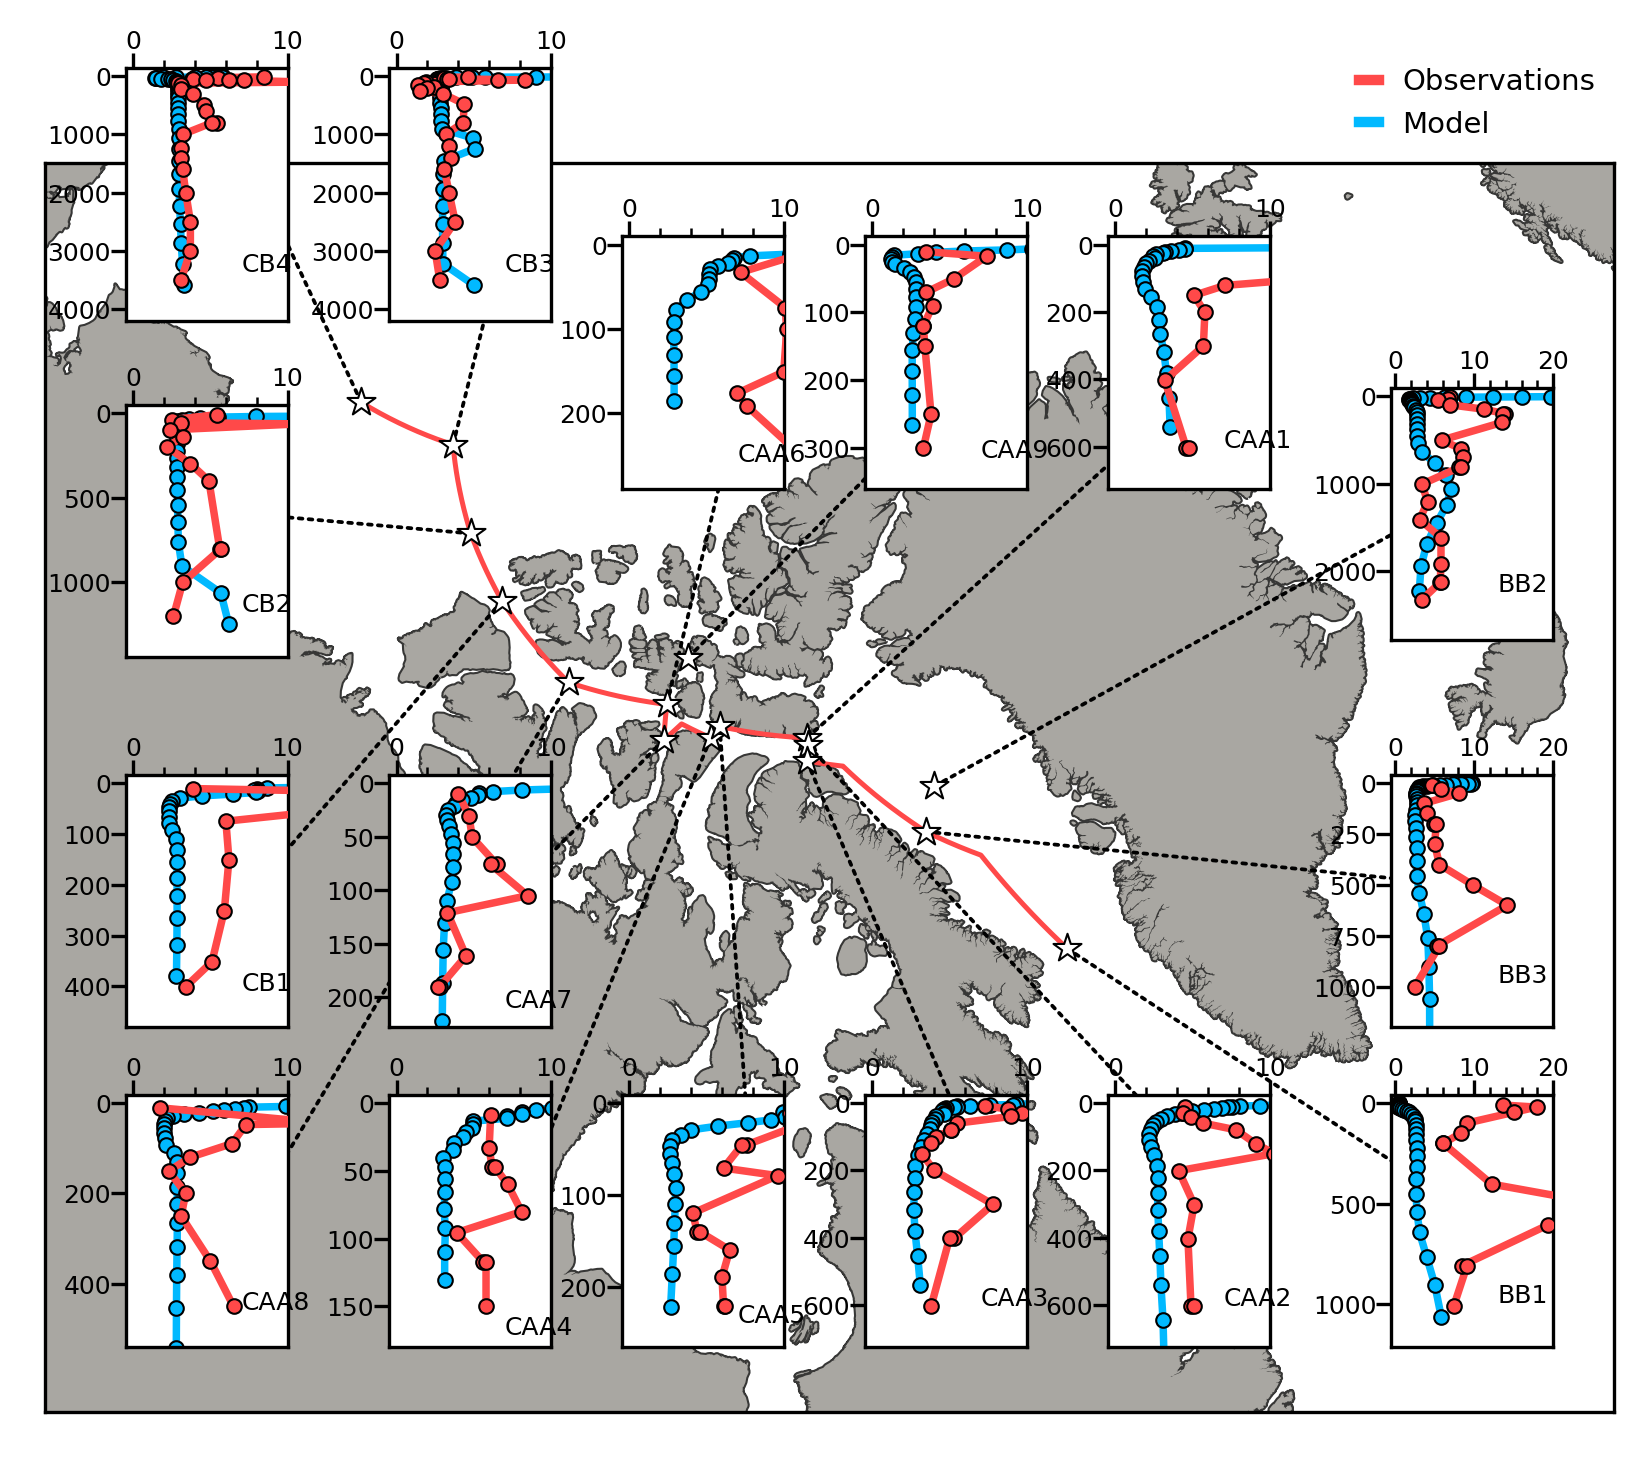

In [14]:
fig, ax, proj = pickle.load(open('/ocean/brogalla/GEOTRACES/pickles/Pb-eval.pickle','rb'))

# profile plots:
ax1  = plt.axes([0.79, 0.17, 0.08, 0.15]) # BB1
ax2  = plt.axes([0.79, 0.59, 0.08, 0.15]) # BB2
ax3  = plt.axes([0.79, 0.36, 0.08, 0.15]) # BB3
ax4  = plt.axes([0.65, 0.68, 0.08, 0.15]) # CAA1
ax5  = plt.axes([0.65, 0.17, 0.08, 0.15]) # CAA2
ax6  = plt.axes([0.53, 0.17, 0.08, 0.15]) # CAA3
ax7  = plt.axes([0.295, 0.17, 0.08, 0.15]) # CAA4
ax8  = plt.axes([0.41, 0.17, 0.08, 0.15]) # CAA5
ax9  = plt.axes([0.41, 0.68, 0.08, 0.15]) # CAA6
ax10 = plt.axes([0.295, 0.36, 0.08, 0.15]) # CAA7
ax11 = plt.axes([0.165, 0.17, 0.08, 0.15]) # CAA8
ax12 = plt.axes([0.53, 0.68, 0.08, 0.15]) # CAA9
ax13 = plt.axes([0.165, 0.36, 0.08, 0.15]) # CB1
ax14 = plt.axes([0.165, 0.58, 0.08, 0.15]) # CB2
ax15 = plt.axes([0.295, 0.78, 0.08, 0.15]) # CB3
ax16 = plt.axes([0.165, 0.78, 0.08, 0.15]) # CB4
axes_list=[ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12, ax13, ax14, ax15, ax16]

for axi in axes_list:
    axi.tick_params(labelsize=5)
    
fig1  = station_profile(ax1, dPb_BB1, depth_BB1, 'BB1', extend=True)
fig2  = station_profile(ax2, dPb_BB2, depth_BB2, 'BB2', extend=True)
fig3  = station_profile(ax3, dPb_BB3, depth_BB3, 'BB3', extend=True)
fig4  = station_profile(ax4, dPb_CAA1, depth_CAA1, 'CAA1')
fig5  = station_profile(ax5, dPb_CAA2, depth_CAA2, 'CAA2')
fig6  = station_profile(ax6, dPb_CAA3, depth_CAA3, 'CAA3')
fig7  = station_profile(ax7, dPb_CAA4, depth_CAA4, 'CAA4')
fig8  = station_profile(ax8, dPb_CAA5, depth_CAA5, 'CAA5')
fig9  = station_profile(ax9, dPb_CAA6, depth_CAA6, 'CAA6')
fig10 = station_profile(ax10, dPb_CAA7, depth_CAA7, 'CAA7')
fig11 = station_profile(ax11, dPb_CAA8, depth_CAA8, 'CAA8')
fig12 = station_profile(ax12, dPb_CAA9, depth_CAA9, 'CAA9')
fig13 = station_profile(ax13, dPb_CB1, depth_CB1, 'CB1')
fig14 = station_profile(ax14, dPb_CB2, depth_CB2, 'CB2')
fig15 = station_profile(ax15, dPb_CB3, depth_CB3, 'CB3')
fig16 = station_profile(ax16, dPb_CB4, depth_CB4, 'CB4')

x_GEOTRACES, y_GEOTRACES = proj(obs_lons[2:18], obs_lats[2:18]) # leave out BB and K stations
ax.scatter(x_GEOTRACES, y_GEOTRACES, marker='*', s=50, linewidth=0.5, zorder=3, edgecolor='k', color='w')

xt, yt = proj(transect_vlons, transect_vlats)
proj.plot(xt, yt, c=profile_colors[0], linewidth=1.2, zorder=2)  

# create lines connecting the profiles:
coordsA = "data"
coordsB = "data"
for i,n in enumerate(range(2,18)):
    xy1 = (x_GEOTRACES[i], y_GEOTRACES[i])
    xy2 = (8, bottom_depths[i]/2)
    axB = axes_list[i]
    con = ConnectionPatch(xyA=xy1, xyB=xy2, axesA=ax, axesB=axB, \
                          coordsA=coordsA, coordsB=coordsB, linestyle="dotted", linewidth=0.9, zorder=2)
    ax.add_artist(con)
    
ax.plot(0, 0, linewidth=2.5, color=profile_colors[0], label="Observations")
ax.plot(0, 0, linewidth=2.5, color=profile_colors[1], label="Model")
ax.legend(loc=(0.83, 1.01), fontsize=7, frameon=False, handlelength=0.7)

# 
# fig.savefig('/ocean/brogalla/GEOTRACES/figures/R1-profile_evaluation-20200327.jpg', bbox_inches='tight', dpi=300)

#### Scatterplot of observations vs. model by region

In [ ]:
def calc_scatter(name):    
    print(f'data from GEOTRACES 2015 stn {name}')
    # observations
    dpb_stn     = Manuel_dMn_nmolL[np.array(Manuel_station_names==name).astype('bool')]
    depth_stn   = Manuel_depths[np.array(Manuel_station_names==name).astype('bool')]
    lon_station = obs_lons[stn_names==name]
    lat_station = obs_lats[stn_names==name]        
        
    # model data:
    model_stni, model_stnj = mf.find_indeces_vector(lon_station, lat_station, lon_model, lat_model)
    model_stni = int(model_stni); model_stnj = int(model_stnj);
    pb_ref     = pb_ref[:,model_stni,model_stnj]*10**9

    pb_ref_masked      = np.ma.masked_where((tmask[:,model_stni, model_stnj] < 0.1), mn_ref)
    
    # match data:
    depth_lower = 50
    depth_upper = 5
    dpb_refm = []
    for depth_obs in depth_stn[(depth_stn < depth_lower) & (depth_stn > depth_upper)]:
        d1 = np.argmin(np.abs(depths_model-depth_obs))
        dpb_refm.append(pb_ref_masked[d1])
    
    dpb_obs = list(dmn_stn[(depth_stn < depth_lower) & (depth_stn > depth_upper)])
    
    return dpb_refm, dpb_obs

In [ ]:
all_stations   = stn_names[2:18]

dmn_ref_all    = np.empty((len(all_stations),50)); 
dmn_obs_all    = np.empty((len(all_stations),50));
dmn_ref_all[:] = np.nan; dmn_obs_all[:] = np.nan;

for n,stn in enumerate(all_stations):
    dmn_ref, dmn_ob = calc_scatter(stn)

    dmn_ref_all[n,0:len(dmn_ref)]        = dmn_ref

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(9.055, 3.74), dpi=300)
st = sns.axes_style("ticks")

with st:   
    for axis in ax:
        line1 = sns.lineplot([0, 20],[0, 20], c='k', linewidth=1.5, zorder=1, ax=axis)
        line1.lines[0].set_linestyle('--')
        axis.set_xlabel('Observed Mn [nM]', fontsize=8)
        axis.set_ylabel('Modelled Mn [nM]',fontsize=8)
        axis.set(xlim=(0, 14.), ylim=(0, 14.))
        axis.tick_params(axis='both', which='major', labelsize=8) 

    ### Left plot ###
    sns.scatterplot(dpb_observ.flatten(), dpb_dirty.flatten() , label=r'Reference', s=40, \
                    edgecolor='k', color=dirty, zorder=2, ax=ax[0])
    sns.scatterplot([np.nanmean(dpb_observ)], [np.nanmean(dpb_dirty)], s=100, linewidth=1.0, \
                    edgecolor='k', marker='s', color=dirty, zorder=3, ax=ax[0])
    ax[0].legend(loc=(0.01, 0.86), frameon=False, fontsize=8)
    
    ### Right plot ###
    sns.scatterplot(dpb_observ.flatten(), dpb_dirty.flatten() , label=r'Reference', s=40, \
                    edgecolor='k', color=dirty, zorder=2, ax=ax[1])
    sns.scatterplot([np.nanmean(dpb_observ)], [np.nanmean(dpb_rivers)], s=100, linewidth=1.0, \
                     edgecolor='k', marker='s', color=rivers, zorder=3, ax=ax[1])
    ax[1].legend(loc=(0.01, 0.86), frameon=False, fontsize=8)
    
#-----------------------------------------------------------------------------------------------------------------------------------
### Full figure ###
fig.text(0.08, 0.88, 'a)', fontsize=9);
fig.text(0.50, 0.88, 'b)', fontsize=9);

# fig.savefig('/ocean/brogalla/GEOTRACES/figures/paper1-202204/R3-model-vs-observations.jpg', \
#                bbox_inches='tight', dpi=300, transparent=True)
# fig.savefig('/ocean/brogalla/GEOTRACES/figures/paper1-202204/R3-model-vs-observations.svg', \
#                bbox_inches='tight', dpi=300, format='svg')